In [1]:
import pandas as pd
import numpy as np
from itertools import product
import scipy.sparse 
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from tqdm import tqdm_notebook
from ipywidgets import IntProgress
import matplotlib.pyplot as plt
import seaborn as sns

## Import Raw Data

In [2]:
items = pd.read_csv(r'D:\Online Learning\Kaggle\competitive-data-science-final-project\items.csv')
shops = pd.read_csv(r'D:\Online Learning\Kaggle\competitive-data-science-final-project\shops.csv')
item_categories = pd.read_csv(r'D:\Online Learning\Kaggle\competitive-data-science-final-project\item_categories.csv')
transactions = pd.read_csv(r'D:\Online Learning\Kaggle\competitive-data-science-final-project\sales_train.csv.gz', compression='gzip', header=0, sep=',', quotechar='"')
# smpsb_df = pd.read_csv(r'D:\Online Learning\Kaggle\competitive-data-science-final-project\sample_submission.csv.gz', compression='gzip', header=0, sep=',', quotechar='"')
test  = pd.read_csv(r'D:\Online Learning\Kaggle\competitive-data-science-final-project\test.csv.gz', 
                       compression='gzip', header=0, sep=',', quotechar='"')

## Visualization

Text(0.5, 1.0, 'Number of items sold in each month')

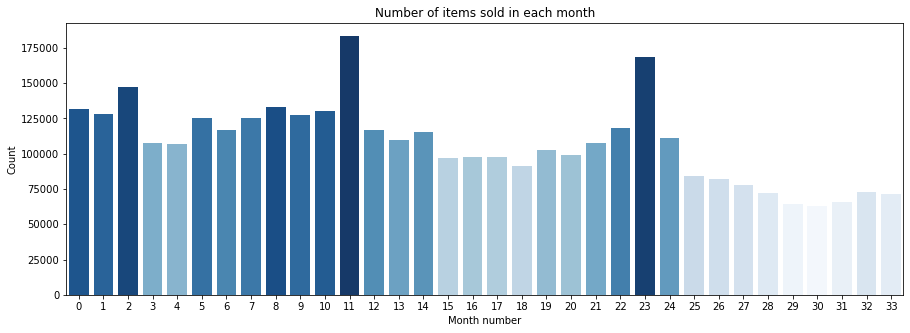

In [3]:
item_cnt_month = transactions.groupby('date_block_num')['item_cnt_day'].sum()
pal = sns.color_palette("Blues", len(item_cnt_month))
rank = item_cnt_month.argsort().argsort() 
plt.figure(figsize=(15,5))
sns.barplot(item_cnt_month.index, item_cnt_month.values, palette=np.array(pal)[rank])
plt.xlabel("Month number")
plt.ylabel("Count")
plt.title("Number of items sold in each month")

Text(0.5, 1.0, 'Number of items sold in each month')

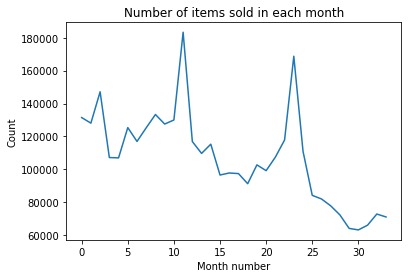

In [4]:
plt.plot(item_cnt_month.index, item_cnt_month.values)
plt.xlabel("Month number")
plt.ylabel("Count")
plt.title("Number of items sold in each month")

Text(0.5, 1.0, 'Popular shops')

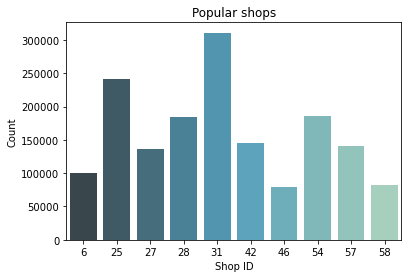

In [5]:
popular_shops = transactions.groupby('shop_id')['item_cnt_day'].sum()
popular_shops = popular_shops.sort_values(ascending=False)[:10]
pal = sns.color_palette("GnBu_d", len(popular_shops))
rank = popular_shops.argsort().argsort() 
sns.barplot(popular_shops.index, popular_shops.values, palette=np.array(pal[::-1])[rank])
plt.xlabel("Shop ID")
plt.ylabel("Count")
plt.title("Popular shops")

Text(0.5, 1.0, 'Number of items per category')

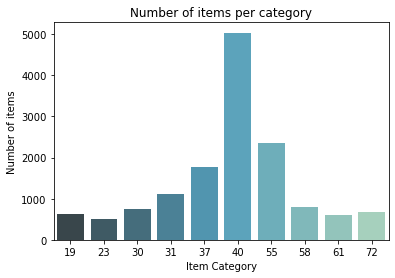

In [6]:
items_per_category = items["item_category_id"].value_counts().iloc[:10]
items_per_category = items_per_category.sort_values(ascending=False)[:10]
pal = sns.color_palette("GnBu_d", len(items_per_category))
rank = items_per_category.argsort().argsort() 
sns.barplot(items_per_category.index, items_per_category.values, palette=np.array(pal[::-1])[rank])
plt.xlabel("Item Category")
plt.ylabel("Number of items")
plt.title("Number of items per category")

## Data Processing

In [7]:
train_shop = pd.unique(transactions["shop_id"])
test_shop = pd.unique(test["shop_id"])
item_remove = [x for x in train_shop if x not in test_shop]
transactions = transactions.loc[~transactions['shop_id'].isin(np.array(item_remove)),:]

In [8]:
def downcast_dtypes(df):
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

In [9]:
### Map categorical with text
l = list(item_categories.item_category_name)
l_cat = l

for ind in range(1,8):
    l_cat[ind] = 'Access'

for ind in range(10,18):
    l_cat[ind] = 'Consoles'

for ind in range(18,25):
    l_cat[ind] = 'Consoles Games'

for ind in range(26,28):
    l_cat[ind] = 'phone games'

for ind in range(28,32):
    l_cat[ind] = 'CD games'

for ind in range(32,37):
    l_cat[ind] = 'Card'

for ind in range(37,43):
    l_cat[ind] = 'Movie'

for ind in range(43,55):
    l_cat[ind] = 'Books'

for ind in range(55,61):
    l_cat[ind] = 'Music'

for ind in range(61,73):
    l_cat[ind] = 'Gifts'

for ind in range(73,79):
    l_cat[ind] = 'Soft'


item_categories['cats'] = l_cat
item_categories.head()
from sklearn import preprocessing

number = preprocessing.LabelEncoder()
item_categories['cats'] = number.fit_transform(item_categories.cats)
item_categories.head()

,item_category_name,item_category_id,cats
0,PC - Гарнитуры/Наушники,0,9
1,Аксессуары - PS2,1,0
2,Аксессуары - PS3,2,0
3,Аксессуары - PS4,3,0
4,Аксессуары - PSP,4,0


In [10]:
items = items.merge(item_categories[["item_category_id", "cats"]], on = "item_category_id", how = "left")

In [11]:
transactions = pd.merge(transactions, items, on='item_id', how='left')
transactions = transactions.drop('item_name', axis=1)

from itertools import product
index_cols = ['shop_id', 'item_id', 'date_block_num']

grid = []
for block_num in transactions['date_block_num'].unique():
    cur_shops = transactions.loc[transactions['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = transactions.loc[transactions['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])), dtype='int32'))
grid = pd.DataFrame(np.vstack(grid), columns = index_cols, dtype=np.int32)

## Mean Encoding

In [12]:
### Mean Encoding 2
mean_transactions = transactions.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day':'sum','item_price':np.mean}).reset_index()
mean_transactions = pd.merge(grid,mean_transactions,on=['date_block_num', 'shop_id', 'item_id'],how='left').fillna(0)
mean_transactions = pd.merge(mean_transactions, items, on='item_id',how='left')
mean_transactions.head()

,shop_id,item_id,date_block_num,item_cnt_day,item_price,item_name,item_category_id,cats
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37,7
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58,8
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58,8
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,8
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,8


In [13]:
for type_id in ['item_id', 'shop_id', 'item_category_id']:
    print(type_id)
    for column_id, aggregator, aggtype in [('item_price',np.mean,'avg'),('item_cnt_day',np.sum,'sum'),('item_cnt_day',np.mean,'avg')]:
        
        mean_df = transactions.groupby([type_id,'date_block_num']).aggregate(aggregator).reset_index()[[column_id,type_id,'date_block_num']]
        mean_df.columns = [type_id+'_'+aggtype+'_'+column_id,type_id,'date_block_num']
        mean_transactions = pd.merge(mean_transactions, mean_df, on=['date_block_num',type_id], how='left')

item_id
shop_id
item_category_id


In [14]:
del grid, mean_df, transactions
import gc
gc.collect()

41

## Lag Features

In [15]:
lag_variables  = list(mean_transactions.columns[8:])+['item_cnt_day']
lags = [1, 3, 6, 12]
from tqdm import tqdm_notebook
for lag in tqdm_notebook(lags):
    sales_new_df = mean_transactions.copy()
    sales_new_df.date_block_num += lag
    sales_new_df = sales_new_df[['date_block_num','shop_id','item_id']+lag_variables]
    sales_new_df.columns = ['date_block_num','shop_id','item_id']+ [lag_feat+'_lag_'+str(lag) for lag_feat in lag_variables]
    mean_transactions = pd.merge(mean_transactions, sales_new_df,on=['date_block_num','shop_id','item_id'] ,how='left')

<ipython-input-15-259e97236427>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for lag in tqdm_notebook(lags):


In [16]:
del sales_new_df
import gc
gc.collect()

25

In [17]:
mean_transactions = downcast_dtypes(mean_transactions)

## Fill NA

In [18]:
mean_transactions = mean_transactions[mean_transactions['date_block_num']>12]
for feat in mean_transactions.columns:
    if 'item_cnt' in feat:
        mean_transactions[feat]=mean_transactions[feat].fillna(0)
    elif 'item_price' in feat:
        mean_transactions[feat]=mean_transactions[feat].fillna(mean_transactions[feat].median())    

## Drop Columns

In [19]:
## Drop all columns which are not lagged
cols_to_drop = lag_variables[:-1] + ['item_price', 'item_name']

In [20]:
training = mean_transactions.drop(cols_to_drop, axis=1)
training = downcast_dtypes(training)

## XGBOSTING

In [21]:
import xgboost as xgb
xgbtrain = xgb.DMatrix(training.iloc[:, training.columns != 'item_cnt_day'].values, training.iloc[:, training.columns == 'item_cnt_day'].values)
param = {'max_depth':10, 
         'subsample':1,
         'min_child_weight':0.5,
         'eta':0.3, 
         'num_round':1000, 
         'seed':1,
         'silent':0,
         'eval_metric':'rmse'} # random parameters
bst = xgb.train(param, xgbtrain)

[01:02:51] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\learner.cc:328: 
Parameters: { num_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:02:52] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\gbm\gbtree.cc:138: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


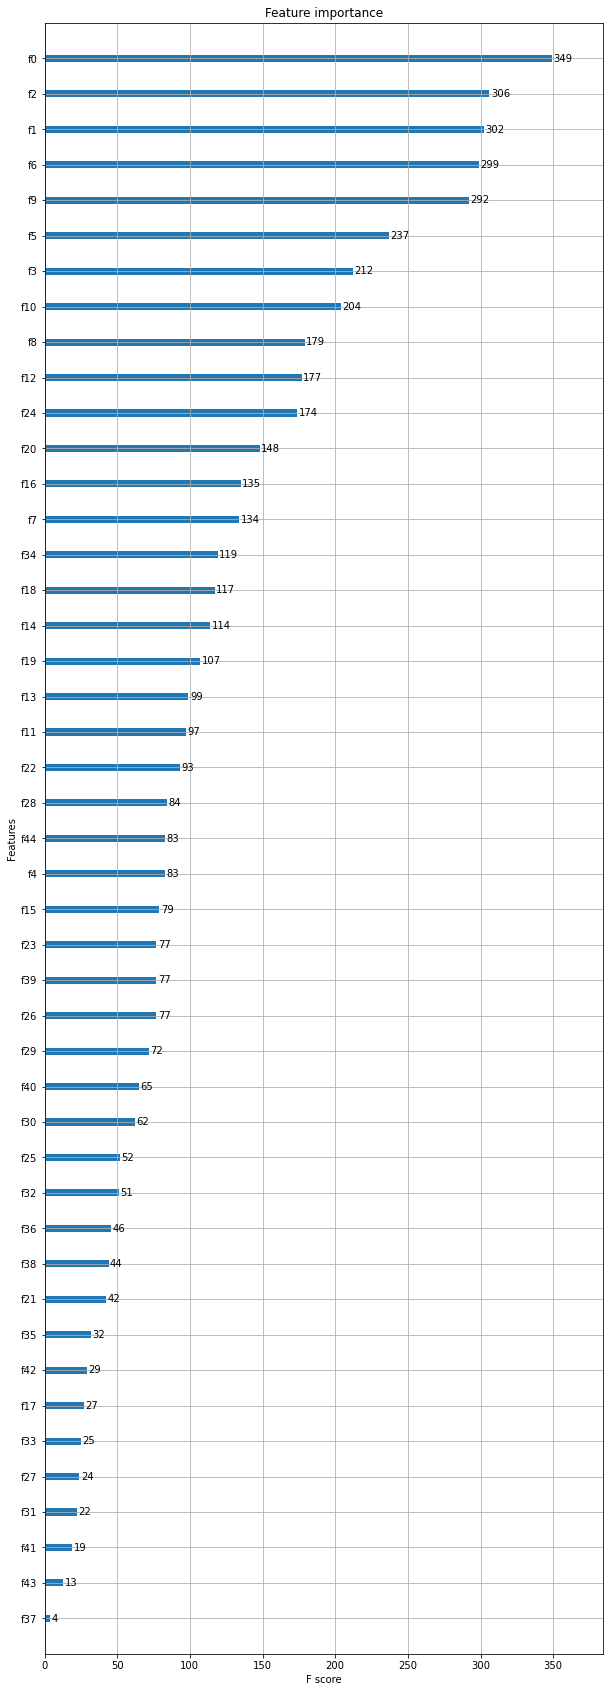

In [22]:
## Important features
x=xgb.plot_importance(bst)
x.figure.set_size_inches(10, 30)

In [23]:
test['date_block_num'] = 34
test = pd.merge(test, items, on='item_id', how='left')
from tqdm import tqdm_notebook
for lag in tqdm_notebook(lags):
    sales_new_df = mean_transactions.copy()
    sales_new_df.date_block_num += lag
    sales_new_df = sales_new_df[['date_block_num','shop_id','item_id']+lag_variables]
    sales_new_df.columns = ['date_block_num','shop_id','item_id']+ [lag_feat+'_lag_'+str(lag) for lag_feat in lag_variables]
    test = pd.merge(test, sales_new_df,on=['date_block_num','shop_id','item_id'] ,how='left')

<ipython-input-23-c58dd68c9259>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for lag in tqdm_notebook(lags):


In [24]:
test = test.drop(['ID', 'item_name'], axis=1)
for feat in test.columns:
    if 'item_cnt' in feat:
        test[feat]=test[feat].fillna(0)
    elif 'item_price' in feat:
        test[feat]=test[feat].fillna(test[feat].median())

In [25]:
xgbpredict = xgb.DMatrix(test.values)
pred = bst.predict(xgbpredict)
pd.Series(pred).describe()

count    214200.000000
mean          0.320332
std           4.464871
min          -0.423092
25%           0.058808
50%           0.132862
75%           0.277957
max        1267.683960
dtype: float64

In [26]:
pred = list(map(lambda x: min(20,max(x,0)), list(pred)))
sub_df = pd.DataFrame({'ID':test.index,'item_cnt_month': pred})

In [27]:
pd.Series(pred).describe()

count    214200.000000
mean          0.291037
std           0.741123
min           0.000000
25%           0.058808
50%           0.132862
75%           0.277957
max          20.000000
dtype: float64

In [28]:
sub_df.head()

,ID,item_cnt_month
0,0,0.567707
1,1,0.272621
2,2,0.668920
3,3,0.351498
4,4,3.100030


In [ ]:
# sub_df.to_csv(r'D:\Online Learning\Kaggle\competitive-data-science-final-project\submit_v5.csv',index=False)

In [ ]:
import gc
gc.collect()